In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import pandas as pd
import PIL

from torch import optim
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.utils import save_image
from sklearn.manifold import TSNE

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Question 1

## Dataset & Preprocessing

In [ ]:
train_dataset = pd.read_csv('/content/drive/MyDrive/Deep Learning/Dakshina Dataset/hi/lexicons/hi.translit.sampled.train.tsv', sep = '\t', header = None)
val_dataset = pd.read_csv('/content/drive/MyDrive/Deep Learning/Dakshina Dataset/hi/lexicons/hi.translit.sampled.dev.tsv', sep = '\t', header = None)
test_dataset = pd.read_csv('/content/drive/MyDrive/Deep Learning/Dakshina Dataset/hi/lexicons/hi.translit.sampled.test.tsv', sep = '\t', header = None)

In [ ]:
val_dataset

,0,1,2
0,अंकन,ankan,3
1,अंगकोर,angkor,3
2,अंगिरा,angira,3
3,अंगीठी,angithi,3
4,अंग्रेज,angrej,3
...,...,...,...
4353,होल्डर,holder,3
4354,होशो,hosho,3
4355,ह्यूअर,huar,1
4356,ह्यूअर,hyuar,1


In [ ]:
train_dataset.columns = ['Hindi', 'English', 'dumb']
val_dataset.columns = ['Hindi', 'English', 'dumb']
test_dataset.columns = ['Hindi', 'English', 'dumb']

train_dataset = train_dataset.drop('dumb', axis=1)
val_dataset = val_dataset.drop('dumb', axis=1)
test_dataset = test_dataset.drop('dumb', axis=1)

In [ ]:
val_dataset

,Hindi,English
0,अंकन,ankan
1,अंगकोर,angkor
2,अंगिरा,angira
3,अंगीठी,angithi
4,अंग्रेज,angrej
...,...,...
4353,होल्डर,holder
4354,होशो,hosho
4355,ह्यूअर,huar
4356,ह्यूअर,hyuar


### Preprocess and creating dictionaries

In [ ]:
for row in range(len(train_dataset)):
    if type(train_dataset['English'][row]) == float:
      print(row, train_dataset['English'][row])
# encountered this while creating engliush dicts

19535 nan
20147 nan


In [ ]:
train_dataset = train_dataset.dropna()
val_dataset = val_dataset.dropna()
test_dataset = test_dataset.dropna()


In [ ]:
hindi_chars = sorted(set(''.join(train_dataset['Hindi'].tolist())))             # Sorting all hindi chars

index_to_hindi = {idx: char for idx, char in enumerate(hindi_chars)}            # dict=> index -> hind
hindi_to_index = {char: idx for idx, char in enumerate(hindi_chars)}            # dict=> hindi -> index

In [ ]:
print(index_to_hindi[7])
print(hindi_to_index[index_to_hindi[7]])

उ
7


In [ ]:
eng_chars = sorted(set(''.join(train_dataset['English'].tolist())))             # Sorting all eng chars

index_to_eng = {idx: char for idx, char in enumerate(eng_chars)}                # dict=> index -> hind
eng_to_index = {char: idx for idx, char in enumerate(eng_chars)}                # dict=> eng -> index

In [ ]:
print(index_to_eng[7])
print(eng_to_index[index_to_eng[7]])

h
7


### Creating data loaders

In [ ]:
class Torch_dataset_generator():

  def __init__(self, dataset, eng_to_index, hindi_to_idx):
    self.dataset = dataset
    self.eng_conv = eng_to_index
    self.hindi_conv = hindi_to_idx
    self.max_len = 22

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, index):
    dataset = self.dataset.iloc[index]

    english_word = dataset["English"]
    hindi_word = dataset["Hindi"]

    english_convert = [self.eng_conv[i] for i in english_word]
    hindi_convert = [self.hindi_conv[i] for i in hindi_word]

    english_convert, hindi_convert = torch.tensor(english_convert), torch.tensor(hindi_convert)

    hindi_convert = np.pad(hindi_convert, (0, self.max_len - len(hindi_convert)), 'constant', constant_values=len(self.hindi_conv)-1)
    english_convert = np.pad(english_convert, (0, self.max_len - len(english_convert)), 'constant', constant_values=len(self.eng_conv)-1)

    return torch.tensor(english_convert), torch.tensor(hindi_convert)

In [ ]:
sgn_chars = ['>', '.', '#']                                                     #significant chars for start stop padding

eng_to_index.update({i: len(eng_to_index) + idx for idx,i in enumerate(sgn_chars)})
hindi_to_index.update({i: len(hindi_to_index) + idx for idx,i in enumerate(sgn_chars)})

eng_to_index

{'a': 0,
 'b': 1,
 'c': 2,
 'd': 3,
 'e': 4,
 'f': 5,
 'g': 6,
 'h': 7,
 'i': 8,
 'j': 9,
 'k': 10,
 'l': 11,
 'm': 12,
 'n': 13,
 'o': 14,
 'p': 15,
 'q': 16,
 'r': 17,
 's': 18,
 't': 19,
 'u': 20,
 'v': 21,
 'w': 22,
 'x': 23,
 'y': 24,
 'z': 25,
 '>': 26,
 '.': 27,
 '#': 28}

In [ ]:
# # def padder(batch):

# #   x = [i[0] for i in batch]
# #   y = [i[1] for i in batch]

# #   x = torch.nn.utils.rnn.pad_sequence(x, batch_first = True, padding_value = len(eng_to_index)-1)
# #   y = torch.nn.utils.rnn.pad_sequence(y, batch_first = True, padding_value = len(hindi_to_index)-1)

# #   return x,y

# def padder(batch):
#     x = [i[0] for i in batch]
#     y = [i[1] for i in batch]
#     x = torch.nn.utils.rnn.pad_sequence(x, batch_first = True, padding_value = len(hindi_to_index) - 1)
#     y = torch.nn.utils.rnn.pad_sequence(y, batch_first = True, padding_value = len(hindi_to_index) - 1)
#     return x, y



In [ ]:
train_set = Torch_dataset_generator(train_dataset,eng_to_index, hindi_to_index)
train_loader = DataLoader(train_set, batch_size = 400, shuffle = True)

val_set = Torch_dataset_generator(val_dataset,eng_to_index, hindi_to_index)
val_loader = DataLoader(val_set, batch_size = 400, shuffle = True)

test_set = Torch_dataset_generator(test_dataset,eng_to_index, hindi_to_index)
test_loader = DataLoader(test_set, batch_size = 400, shuffle = True)

## Part a

In [ ]:
class Seq2SeqModel(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers, embedding_size, rnn_lstm, dropout_val):
        super(Seq2SeqModel, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn_lstm = rnn_lstm
        self.embedding_size = embedding_size
        self.dropout_val = dropout_val

        self.encoder_embedding = nn.Embedding(input_size, embedding_size)
        self.decoder_embedding = nn.Embedding(output_size, embedding_size)

        if rnn_lstm == 'RNN':
            self.encoder = nn.RNN(embedding_size, hidden_size, num_layers=num_layers, batch_first=True, dropout = dropout_val)
            self.decoder = nn.RNN(embedding_size, hidden_size, num_layers=num_layers, batch_first=True, dropout = dropout_val)

        elif rnn_lstm == 'LSTM':
            self.encoder = nn.LSTM(embedding_size, hidden_size, num_layers=num_layers, batch_first=True, dropout = dropout_val)
            self.decoder = nn.LSTM(embedding_size, hidden_size, num_layers=num_layers, batch_first=True, dropout = dropout_val)

        self.fc = nn.Linear(hidden_size, output_size)

    def encode(self, source):
        embedded = self.encoder_embedding(source)
        output, hidden = self.encoder(embedded)
        return output, hidden

    def decode(self, input, hidden):
        embedded = self.decoder_embedding(input)
        output, hidden = self.decoder(embedded, hidden)
        output = self.fc(output)
        return output, hidden

    def forward(self, source, target, teacher_forcing_ratio=0.5):
        batch_size = source.size(0)
        target_len = target.size(1)

        encoder_output, hidden = self.encode(source)
        decoder_input = target[:, 0].unsqueeze(1)
        outputs = []

        for t in range(1, target_len):
            decoder_output, hidden = self.decode(decoder_input, hidden)
            outputs.append(decoder_output)
            use_teacher_forcing = True if torch.rand(1).item() < teacher_forcing_ratio else False
            if use_teacher_forcing:
                decoder_input = target[:, t].unsqueeze(1)
            else:
                decoder_input = decoder_output.argmax(dim=2)
        outputs.append(decoder_output)
        outputs = torch.cat(outputs, dim=1)
        outputs = outputs.transpose(2,1)
        return outputs

### Defining models

In [ ]:
rnn_16_1_16 = Seq2SeqModel(len(eng_to_index), len(hindi_to_index), 16, 1, 16,'RNN', 0).to(device)
lstm_16_1_16 = Seq2SeqModel(len(eng_to_index), len(hindi_to_index), 16, 1, 16,'LSTM', 0).to(device)

rnn_16_1_64 = Seq2SeqModel(len(eng_to_index), len(hindi_to_index), 16, 1, 64,'RNN', 0).to(device)
lstm_16_1_64 = Seq2SeqModel(len(eng_to_index), len(hindi_to_index), 16, 1, 64,'LSTM', 0).to(device)

rnn_16_3_16 = Seq2SeqModel(len(eng_to_index), len(hindi_to_index), 16, 3, 16,'RNN', 0).to(device)
lstm_16_3_16 = Seq2SeqModel(len(eng_to_index), len(hindi_to_index), 16, 3, 16,'LSTM', 0).to(device)

rnn_16_3_64 = Seq2SeqModel(len(eng_to_index), len(hindi_to_index), 16, 3, 64,'RNN', 0).to(device)
lstm_16_3_64 = Seq2SeqModel(len(eng_to_index), len(hindi_to_index), 16, 3, 64,'LSTM', 0).to(device)

rnn_64_1_16 = Seq2SeqModel(len(eng_to_index), len(hindi_to_index), 64, 1, 16,'RNN', 0).to(device)
lstm_64_1_16 = Seq2SeqModel(len(eng_to_index), len(hindi_to_index), 64, 1, 16,'LSTM', 0).to(device)

rnn_64_3_16 = Seq2SeqModel(len(eng_to_index), len(hindi_to_index), 64, 3, 16,'RNN', 0).to(device)
lstm_64_3_16 = Seq2SeqModel(len(eng_to_index), len(hindi_to_index), 64, 3, 16,'LSTM', 0).to(device)

rnn_s2s = Seq2SeqModel(len(eng_to_index), len(hindi_to_index), 64, 1, 64,'RNN', 0).to(device)         # input_size, output_size, hidden_size, num_layers, embedding_size, rnn_lstm, dropout_val
lstm_s2s = Seq2SeqModel(len(eng_to_index), len(hindi_to_index), 64, 1, 64,'LSTM', 0).to(device)

rnn_64_3_64 = Seq2SeqModel(len(eng_to_index), len(hindi_to_index), 64, 3, 64,'RNN', 0).to(device)
lstm_64_3_64 = Seq2SeqModel(len(eng_to_index), len(hindi_to_index), 64, 3, 64,'LSTM', 0).to(device)

### Dictionaries check

In [ ]:
hindi_to_index

{'ँ': 0,
 'ं': 1,
 'ः': 2,
 'अ': 3,
 'आ': 4,
 'इ': 5,
 'ई': 6,
 'उ': 7,
 'ऊ': 8,
 'ऋ': 9,
 'ए': 10,
 'ऐ': 11,
 'ऑ': 12,
 'ओ': 13,
 'औ': 14,
 'क': 15,
 'ख': 16,
 'ग': 17,
 'घ': 18,
 'ङ': 19,
 'च': 20,
 'छ': 21,
 'ज': 22,
 'झ': 23,
 'ञ': 24,
 'ट': 25,
 'ठ': 26,
 'ड': 27,
 'ढ': 28,
 'ण': 29,
 'त': 30,
 'थ': 31,
 'द': 32,
 'ध': 33,
 'न': 34,
 'प': 35,
 'फ': 36,
 'ब': 37,
 'भ': 38,
 'म': 39,
 'य': 40,
 'र': 41,
 'ल': 42,
 'व': 43,
 'श': 44,
 'ष': 45,
 'स': 46,
 'ह': 47,
 '़': 48,
 'ा': 49,
 'ि': 50,
 'ी': 51,
 'ु': 52,
 'ू': 53,
 'ृ': 54,
 'ॅ': 55,
 'े': 56,
 'ै': 57,
 'ॉ': 58,
 'ो': 59,
 'ौ': 60,
 '्': 61,
 'ॐ': 62,
 '>': 63,
 '.': 64,
 '#': 65}

In [ ]:
index_to_hindi

{0: 'ँ',
 1: 'ं',
 2: 'ः',
 3: 'अ',
 4: 'आ',
 5: 'इ',
 6: 'ई',
 7: 'उ',
 8: 'ऊ',
 9: 'ऋ',
 10: 'ए',
 11: 'ऐ',
 12: 'ऑ',
 13: 'ओ',
 14: 'औ',
 15: 'क',
 16: 'ख',
 17: 'ग',
 18: 'घ',
 19: 'ङ',
 20: 'च',
 21: 'छ',
 22: 'ज',
 23: 'झ',
 24: 'ञ',
 25: 'ट',
 26: 'ठ',
 27: 'ड',
 28: 'ढ',
 29: 'ण',
 30: 'त',
 31: 'थ',
 32: 'द',
 33: 'ध',
 34: 'न',
 35: 'प',
 36: 'फ',
 37: 'ब',
 38: 'भ',
 39: 'म',
 40: 'य',
 41: 'र',
 42: 'ल',
 43: 'व',
 44: 'श',
 45: 'ष',
 46: 'स',
 47: 'ह',
 48: '़',
 49: 'ा',
 50: 'ि',
 51: 'ी',
 52: 'ु',
 53: 'ू',
 54: 'ृ',
 55: 'ॅ',
 56: 'े',
 57: 'ै',
 58: 'ॉ',
 59: 'ो',
 60: 'ौ',
 61: '्',
 62: 'ॐ'}

### Accuracy function

In [ ]:
def accuracy_by_word(y_pred, y_test):
  # print(y_pred.shape)
  y_pred = y_pred.argmax(1)
  acc = 0
  for i in range(len(y_test)):
    len_w = 0
    for j in range(len(y_test[i])):
      if(y_test[i][j] == 65):
        break
      len_w += 1
    # print(y_test[i][:len_w], y_pred[i][:len_w])
    if torch.equal(y_test[i][:len_w], y_pred[i][:len_w]):
      acc = acc + 1
  acc = acc / len(y_test)
  return 100*acc


def accuracy_by_char(y_pred, y_test):
    # print(y_pred.shape)
    y_pred = y_pred.argmax(1)
    acc = 0
    # print(y_pred.shape, y_test.shape)
    for i in range(len(y_pred)):
      w_acc = 0
      len_w = 0
      for j in range(len(y_pred[i])):
          if y_pred[i][j] == 65:
            break
          if y_pred[i][j] == y_test[i][j]:
              w_acc += 1
          len_w = len_w + 1
      acc += w_acc/max(1,len_w)

    return 100*acc/(len(y_test))

### Training function

In [ ]:
def check(model):
  for eng, hindi in val_loader:
    eng = eng.to(device)
    hindi = hindi.to(device)

    # eng = eng.view(eng.shape[0], -1)                                 # Flattening the list

    # optimizer.zero_grad()

    output = rnn_s2s(eng, hindi)
    print("".join([index_to_hindi[i.item()] for i in hindi[0] if i <63]))
    # print(output.shape)
    # print(torch.argmax(output,dim=1))
    print("".join([index_to_hindi[i.item()] for i in torch.argmax(output,dim=1)[0] if i <63]))
    print(accuracy_by_word(output,hindi))
    break

In [ ]:
def checker(model):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.01)                            # Defining Loss, Optimizer and Learning rate

  num_epochs = 15

  overall_train_error = []
  overall_train_accw = []
  overall_train_accc = []


  overall_val_error = []
  overall_val_accw = []
  overall_val_accc = []


  for epoch in range(num_epochs):
    print('EPOCH :', epoch+1)
    epoch_loss = 0
    epoch_accw = 0
    epoch_accc = 0

    for eng, hindi in train_loader:
      eng = eng.to(device)
      hindi = hindi.to(device)

      # eng = eng.view(eng.shape[0], -1)                                 # Flattening the list

      optimizer.zero_grad()

      output = model(eng, hindi)
      # output1 = output.transpose(2, 1)
      # output1 = output1.view(-1, output1.shape[2])
      # hindi1 = hindi.view(-1)
      # output = output.permute(0, 2, 1)
      # print(output.shape, hindi.shape)
      loss = criterion(output, hindi)
      # break
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()
      epoch_accw += accuracy_by_word(output,hindi)
      epoch_accc += accuracy_by_char(output,hindi)

    overall_train_accw.append(epoch_accw/len(train_loader))
    overall_train_accc.append(epoch_accc/len(train_loader))
    overall_train_error.append(epoch_loss/len(train_loader))
    print("Training loss =", epoch_loss/len(train_loader))
    print("Training accuracy_by_word =", epoch_accw/len(train_loader))
    print("Training accuracy_by_char =", epoch_accc/len(train_loader))
    print()


    epoch_loss = 0
    epoch_accw = 0
    epoch_accc = 0

    for eng, hindi in val_loader:
      eng = eng.to(device)
      hindi = hindi.to(device)

      # eng = eng.view(eng.shape[0], -1)                                 # Flattening the list

      # optimizer.zero_grad()

      output = model(eng)
      # output = output.permute(0, 2, 1)

      # output1 = output.transpose(2, 1)
      # output1 = output1.view(-1, output1.shape[2])
      # hindi1 = hindi.view(-1)
      loss = criterion(output, hindi)

      epoch_loss += loss.item()

      epoch_accw += accuracy_by_word(output,hindi)
      epoch_accc += accuracy_by_char(output,hindi)

    overall_val_accw.append(epoch_accw/len(val_loader))
    overall_val_accc.append(epoch_accc/len(val_loader))
    overall_val_error.append(epoch_loss/len(val_loader))
    print("Validation loss =", epoch_loss/len(val_loader))
    print("Validation accuracy_by_word =", epoch_accw/len(val_loader))
    print("Validation accuracy_by_char =", epoch_accc/len(val_loader))
    print()

  return overall_train_error, overall_train_accw, overall_train_accc, overall_val_error, overall_val_accw, overall_val_accc

### Running RNN and LSTM single model

In [ ]:
rnn_train_error, rnn_train_accw, rnn_train_accc, rnn_val_error, rnn_val_accw, rnn_val_accc = checker(rnn_s2s)

EPOCH : 1
Training loss = 0.787461952985944
Training accuracy_by_word = 4.563955044153064
Training accuracy_by_char = 58.4768808636474

Validation loss = 0.5292991643602197
Validation accuracy_by_word = 5.340909090909091
Validation accuracy_by_char = 63.70699739252627

EPOCH : 2
Training loss = 0.5139869373996515
Training accuracy_by_word = 11.869190973151369
Training accuracy_by_char = 66.11390461248135

Validation loss = 0.4845633100379597
Validation accuracy_by_word = 2.8861097003555103
Validation accuracy_by_char = 60.721515172232564

EPOCH : 3
Training loss = 0.4841374635427922
Training accuracy_by_word = 9.247524752475247
Training accuracy_by_char = 68.0722250346559

Validation loss = 0.4700875377113169
Validation accuracy_by_word = 7.218892839004571
Validation accuracy_by_char = 68.04377766088663

EPOCH : 4
Training loss = 0.4517359390250734
Training accuracy_by_word = 10.704954954954955
Training accuracy_by_char = 69.42308608167487

Validation loss = 0.3738972998478196
Validati

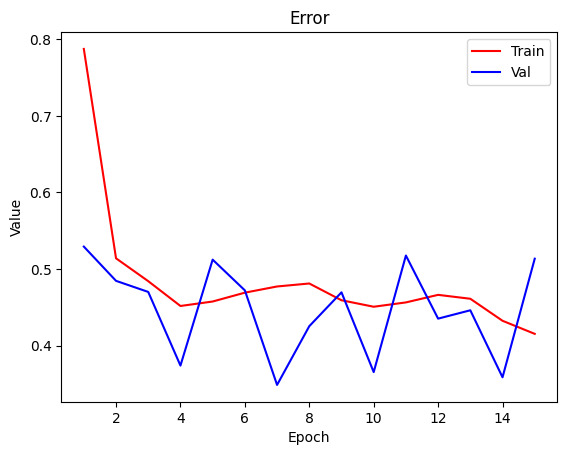

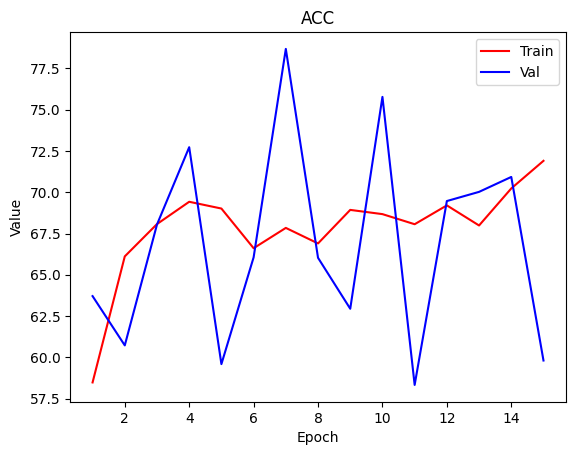

In [ ]:
plt.plot(range(1,16), rnn_train_error, color ='r')
plt.plot(range(1,16), rnn_val_error, color ='b')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(['Train','Val'])
plt.title('Error')
plt.show()

print()

plt.plot(range(1,16), rnn_train_accc, color ='r')
plt.plot(range(1,16), rnn_val_accc, color ='b')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(['Train','Val'])
plt.title('ACC')
plt.show()

print()

In [ ]:
lstm_train_error, lstm_train_accw, lstm_train_accc, lstm_val_error, lstm_val_accw, lstm_val_accc = checker(lstm_s2s)

EPOCH : 1
Training loss = 0.8198462257514129
Training accuracy_by_word = 3.7544153063955044
Training accuracy_by_char = 51.00342664243728

Validation loss = 0.4681748409162868
Validation accuracy_by_word = 10.76320467242255
Validation accuracy_by_char = 67.93864403823144

EPOCH : 2
Training loss = 0.48340745558878323
Training accuracy_by_word = 8.893207563999644
Training accuracy_by_char = 64.99671541842847

Validation loss = 0.4325343519449234
Validation accuracy_by_word = 7.417089893346877
Validation accuracy_by_char = 66.47240646570573

EPOCH : 3
Training loss = 0.47453852430791466
Training accuracy_by_word = 8.69112924805994
Training accuracy_by_char = 63.27772332049777

Validation loss = 0.3932043977759101
Validation accuracy_by_word = 6.937150837988827
Validation accuracy_by_char = 67.79778460986562

EPOCH : 4
Training loss = 0.44381637414833447
Training accuracy_by_word = 8.373829274819375
Training accuracy_by_char = 65.66081837250847

Validation loss = 0.38296262648972595
Valid

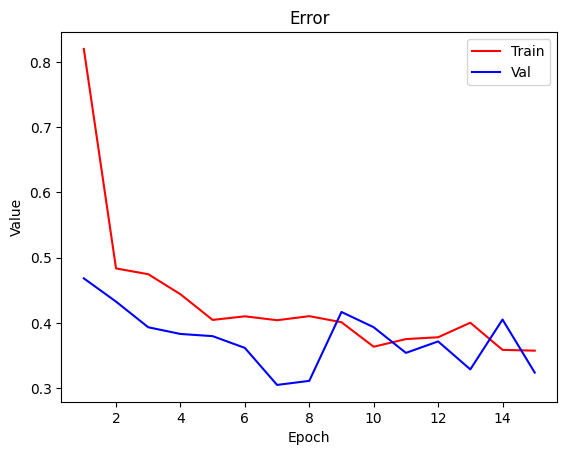

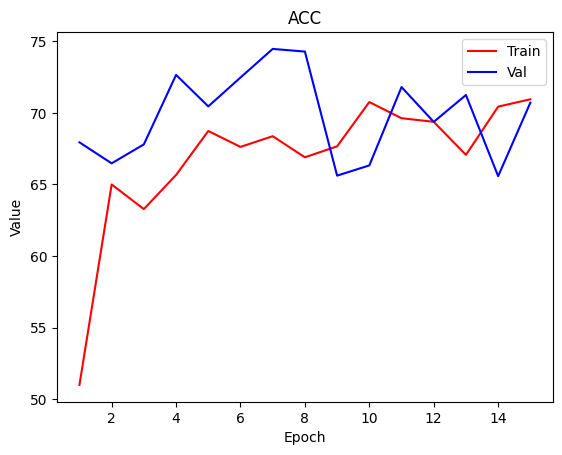

In [ ]:
plt.plot(range(1,16), lstm_train_error, color ='r')
plt.plot(range(1,16), lstm_val_error, color ='b')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(['Train','Val'])
plt.title('Error')
plt.show()

print()

plt.plot(range(1,16), lstm_train_accc, color ='r')
plt.plot(range(1,16), lstm_val_accc, color ='b')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(['Train','Val'])
plt.title('ACC')
plt.show()

print()

In [ ]:
print('RNN check')
check(rnn_s2s)
print()
print('LSTM')
check(lstm_s2s)

अधिकांशत
अंंक््त
0.25


## Part b

### RUnning all models

In [ ]:
rnn_16_1_16_train_error, rnn_16_1_16_train_accw, rnn_16_1_16_train_accc, rnn_16_1_16_val_error, rnn_16_1_16_val_accw, rnn_16_1_16_val_accc = checker(rnn_16_1_16)
lstm_16_1_16_train_error, lstm_16_1_16_train_accw, lstm_16_1_16_train_accc, lstm_16_1_16_val_error, lstm_16_1_16_val_accw, lstm_16_1_16_val_accc = checker(lstm_16_1_16)

rnn_16_1_64_train_error, rnn_16_1_64_train_accw, rnn_16_1_64_train_accc, rnn_16_1_64_val_error, rnn_16_1_64_val_accw, rnn_16_1_64_val_accc = checker(rnn_16_1_64 )
lstm_16_1_64_train_error, lstm_16_1_64_train_accw, lstm_16_1_64_train_accc, lstm_16_1_64_val_error, lstm_16_1_64_val_accw, lstm_16_1_64_val_accc = checker(lstm_16_1_64)

rnn_16_3_16_train_error, rnn_16_3_16_train_accw, rnn_16_3_16_train_accc, rnn_16_3_16_val_error, rnn_16_3_16_val_accw, rnn_16_3_16_val_accc = checker(rnn_16_3_16 )
lstm_16_3_16_train_error, lstm_16_3_16_train_accw, lstm_16_3_16_train_accc, lstm_16_3_16_val_error, lstm_16_3_16_val_accw, lstm_16_3_16_val_accc = checker(lstm_16_3_16)

rnn_16_3_64_train_error, rnn_16_3_64_train_accw, rnn_16_3_64_train_accc, rnn_16_3_64_val_error, rnn_16_3_64_val_accw, rnn_16_3_64_val_accc = checker(rnn_16_3_64 )
lstm_16_3_64_train_error, lstm_16_3_64_train_accw, lstm_16_3_64_train_accc, lstm_16_3_64_val_error, lstm_16_3_64_val_accw, lstm_16_3_64_val_accc = checker(lstm_16_3_64)


rnn_64_1_16_train_error, rnn_64_1_16_train_accw, rnn_64_1_16_train_accc, rnn_64_1_16_val_error, rnn_64_1_16_val_accw, rnn_64_1_16_val_accc = checker(rnn_64_1_16 )
lstm_64_1_16_train_error, lstm_64_1_16_train_accw, lstm_64_1_16_train_accc, lstm_64_1_16_val_error, lstm_64_1_16_val_accw, lstm_64_1_16_val_accc = checker(lstm_64_1_16)

rnn_64_3_16_train_error, rnn_64_3_16_train_accw, rnn_64_3_16_train_accc, rnn_64_3_16_val_error, rnn_64_3_16_val_accw, rnn_64_3_16_val_accc = checker(rnn_64_3_16 )
lstm_64_3_16_train_error, lstm_64_3_16_train_accw, lstm_64_3_16_train_accc, lstm_64_3_16_val_error, lstm_64_3_16_val_accw, lstm_64_3_16_val_accc = checker(lstm_64_3_16)

rnn_64_3_64_train_error, rnn_64_3_64_train_accw, rnn_64_3_64_train_accc, rnn_64_3_64_val_error, rnn_64_3_64_val_accw, rnn_64_3_64_val_accc = checker(rnn_64_3_64 )
lstm_64_3_64_train_error, lstm_64_3_64_train_accw, lstm_64_3_64_train_accc, lstm_64_3_64_val_error, lstm_64_3_64_val_accw, lstm_64_3_64_val_accc = checker(lstm_64_3_64)

EPOCH : 1
Training loss = 1.267093994595983
Training accuracy_by_word = 1.714075461600214
Training accuracy_by_char = 40.76992417281612

Validation loss = 0.7926057522947138
Validation accuracy_by_word = 0.6898171660741493
Validation accuracy_by_char = 53.707734159638676

EPOCH : 2
Training loss = 0.6611444104362179
Training accuracy_by_word = 5.13045223441263
Training accuracy_by_char = 64.05815032632978

Validation loss = 0.7500586861913855
Validation accuracy_by_word = 7.117191467750127
Validation accuracy_by_char = 58.697419699467076

EPOCH : 3
Training loss = 0.6160659916229076
Training accuracy_by_word = 7.323008652216573
Training accuracy_by_char = 66.49409182456832

Validation loss = 0.6282068463889036
Validation accuracy_by_word = 5.37163534789233
Validation accuracy_by_char = 63.89347730030817

EPOCH : 4
Training loss = 0.6003741248770877
Training accuracy_by_word = 6.538288288288288
Training accuracy_by_char = 65.77147141694901

Validation loss = 0.5008845275098627
Validatio

### Comparison

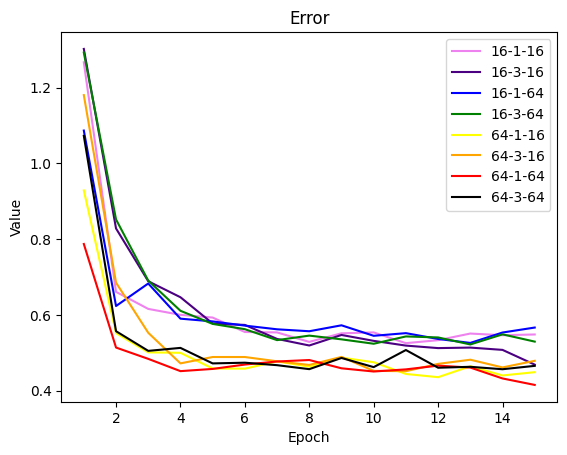

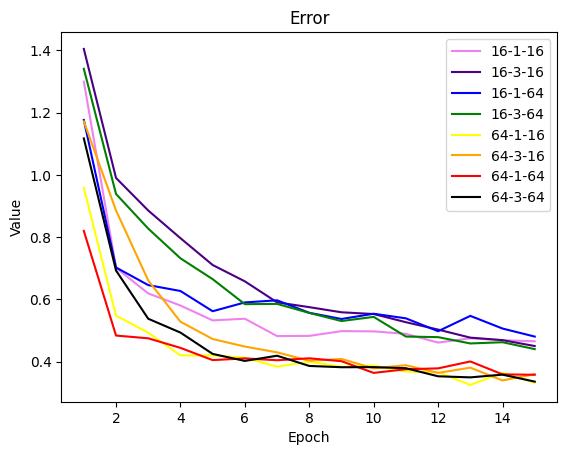

In [ ]:
plt.plot(range(1,16), rnn_16_1_16_train_error, color ='violet')
plt.plot(range(1,16), rnn_16_3_16_train_error, color ='indigo')
plt.plot(range(1,16), rnn_16_1_64_train_error, color ='blue')
plt.plot(range(1,16), rnn_16_3_64_train_error, color ='green')
plt.plot(range(1,16), rnn_64_1_16_train_error, color ='yellow')
plt.plot(range(1,16), rnn_64_3_16_train_error, color ='orange')
plt.plot(range(1,16), rnn_train_error, color ='r')
plt.plot(range(1,16), rnn_64_3_64_train_error, color ='black')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(['16-1-16', '16-3-16', '16-1-64', '16-3-64', '64-1-16', '64-3-16', '64-1-64', '64-3-64'])
plt.title('Error')
plt.show()

print()

plt.plot(range(1,16), lstm_16_1_16_train_error, color ='violet')
plt.plot(range(1,16), lstm_16_3_16_train_error, color ='indigo')
plt.plot(range(1,16), lstm_16_1_64_train_error, color ='blue')
plt.plot(range(1,16), lstm_16_3_64_train_error, color ='green')
plt.plot(range(1,16), lstm_64_1_16_train_error, color ='yellow')
plt.plot(range(1,16), lstm_64_3_16_train_error, color ='orange')
plt.plot(range(1,16), lstm_train_error, color ='r')
plt.plot(range(1,16), lstm_64_3_64_train_error, color ='black')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(['16-1-16', '16-3-16', '16-1-64', '16-3-64', '64-1-16', '64-3-16', '64-1-64', '64-3-64'])
plt.title('Error')
plt.show()

print()

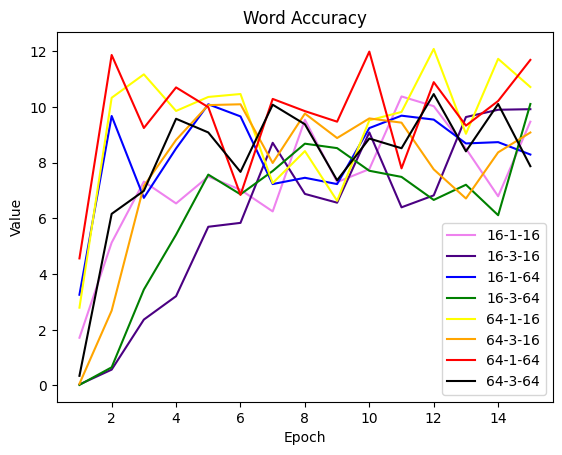

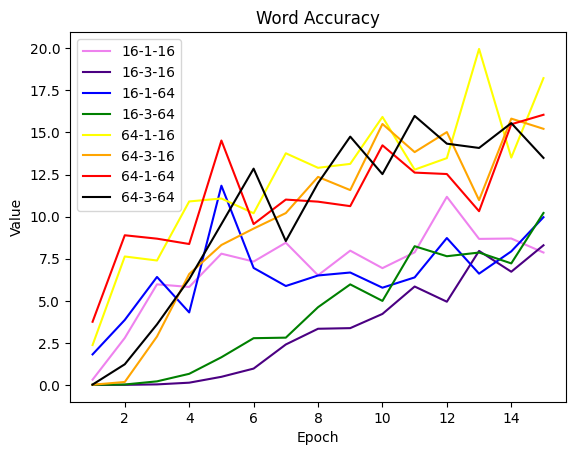

In [ ]:
plt.plot(range(1,16), rnn_16_1_16_train_accw, color ='violet')
plt.plot(range(1,16), rnn_16_3_16_train_accw, color ='indigo')
plt.plot(range(1,16), rnn_16_1_64_train_accw, color ='blue')
plt.plot(range(1,16), rnn_16_3_64_train_accw, color ='green')
plt.plot(range(1,16), rnn_64_1_16_train_accw, color ='yellow')
plt.plot(range(1,16), rnn_64_3_16_train_accw, color ='orange')
plt.plot(range(1,16), rnn_train_accw, color ='r')
plt.plot(range(1,16), rnn_64_3_64_train_accw, color ='black')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(['16-1-16', '16-3-16', '16-1-64', '16-3-64', '64-1-16', '64-3-16', '64-1-64', '64-3-64'])
plt.title('Word Accuracy')
plt.show()

print()

plt.plot(range(1,16), lstm_16_1_16_train_accw, color ='violet')
plt.plot(range(1,16), lstm_16_3_16_train_accw, color ='indigo')
plt.plot(range(1,16), lstm_16_1_64_train_accw, color ='blue')
plt.plot(range(1,16), lstm_16_3_64_train_accw, color ='green')
plt.plot(range(1,16), lstm_64_1_16_train_accw, color ='yellow')
plt.plot(range(1,16), lstm_64_3_16_train_accw, color ='orange')
plt.plot(range(1,16), lstm_train_accw, color ='r')
plt.plot(range(1,16), lstm_64_3_64_train_accw, color ='black')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(['16-1-16', '16-3-16', '16-1-64', '16-3-64', '64-1-16', '64-3-16', '64-1-64', '64-3-64'])
plt.title('Word Accuracy')
plt.show()

print()

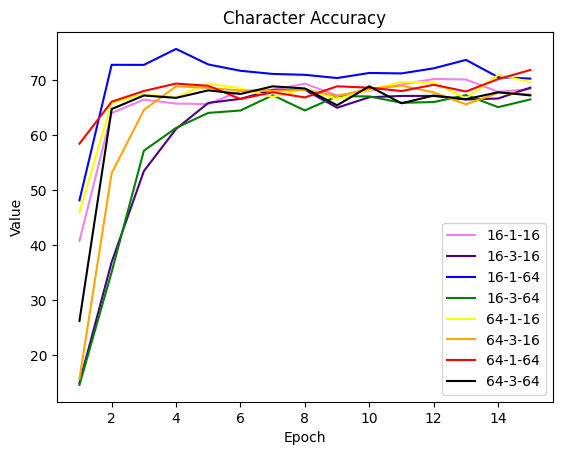

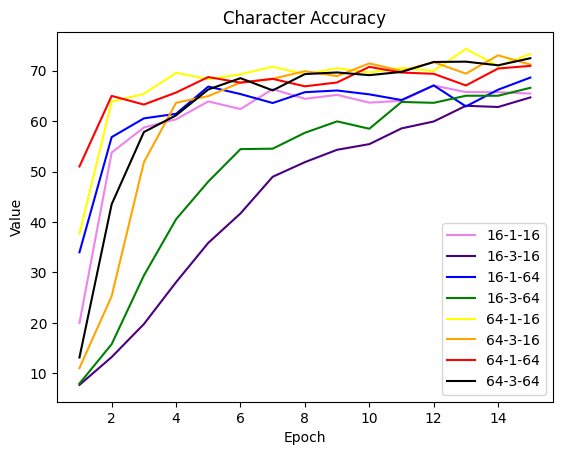

In [ ]:
plt.plot(range(1,16), rnn_16_1_16_train_accc, color ='violet')
plt.plot(range(1,16), rnn_16_3_16_train_accc, color ='indigo')
plt.plot(range(1,16), rnn_16_1_64_train_accc, color ='blue')
plt.plot(range(1,16), rnn_16_3_64_train_accc, color ='green')
plt.plot(range(1,16), rnn_64_1_16_train_accc, color ='yellow')
plt.plot(range(1,16), rnn_64_3_16_train_accc, color ='orange')
plt.plot(range(1,16), rnn_train_accc, color ='r')
plt.plot(range(1,16), rnn_64_3_64_train_accc, color ='black')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(['16-1-16', '16-3-16', '16-1-64', '16-3-64', '64-1-16', '64-3-16', '64-1-64', '64-3-64'])
plt.title('Character Accuracy')
plt.show()

print()

plt.plot(range(1,16), lstm_16_1_16_train_accc, color ='violet')
plt.plot(range(1,16), lstm_16_3_16_train_accc, color ='indigo')
plt.plot(range(1,16), lstm_16_1_64_train_accc, color ='blue')
plt.plot(range(1,16), lstm_16_3_64_train_accc, color ='green')
plt.plot(range(1,16), lstm_64_1_16_train_accc, color ='yellow')
plt.plot(range(1,16), lstm_64_3_16_train_accc, color ='orange')
plt.plot(range(1,16), lstm_train_accc, color ='r')
plt.plot(range(1,16), lstm_64_3_64_train_accc, color ='black')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(['16-1-16', '16-3-16', '16-1-64', '16-3-64', '64-1-16', '64-3-16', '64-1-64', '64-3-64'])
plt.title('Character Accuracy')
plt.show()

print()

In [ ]:
table_rnn = [[16, 1, 16, rnn_16_1_16_train_accc[-1] ], [16, 3, 16, rnn_16_3_16_train_accc[-1] ], [16, 1 , 64, rnn_16_1_64_train_accc[-1]  ], [16, 3, 64, rnn_16_3_64_train_accc[-1]],
             [64, 1, 16, rnn_64_1_16_train_accc[-1] ], [64, 3, 16, rnn_64_3_16_train_accc[-1] ], [64, 1 , 64, rnn_train_accc[-1] ],          [64, 3, 64, rnn_64_3_64_train_accc[-1] ] ]

table_lstm = [[16, 1, 16, lstm_16_1_16_train_accc[-1] ], [16, 3, 16, lstm_16_3_16_train_accc[-1] ], [16, 1 , 64, lstm_16_1_64_train_accc[-1]  ], [16, 3, 64, lstm_16_3_64_train_accc[-1]],
             [64, 1, 16, lstm_64_1_16_train_accc[-1] ], [64, 3, 16, lstm_64_3_16_train_accc[-1] ], [64, 1 , 64, lstm_train_accc[-1] ], [64, 3, 64, lstm_64_3_64_train_accc[-1] ] ]

In [ ]:
for i in table_rnn:
  print(len(i))

4
4
4
4
4
4
4
4


In [ ]:
np.array(table_rnn)

<ipython-input-267-4db47b52683d>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(table_rnn)


array([list([16, 1, 16, 68.41154537274586]),
       list([16, 3, 16, 68.68376854976484]),
       list([16, 1, 64, 70.3281241191441]), list([16, 3, 64]),
       66.53705526251755, list([64, 1, 16, 69.7391861549659]),
       list([64, 3, 16, 67.45669976165028]),
       list([64, 1, 64, 71.90421585786689]),
       list([64, 3, 64, 67.27042713404101])], dtype=object)

In [ ]:
results1 = pd.DataFrame(table_rnn)
results2 = pd.DataFrame(table_lstm)

results1.columns = ['Hidden size', 'Num layers', 'EMbedding size', 'Accuracy by character']
results2.columns = ['Hidden size', 'Num layers', 'EMbedding size', 'Accuracy by character']


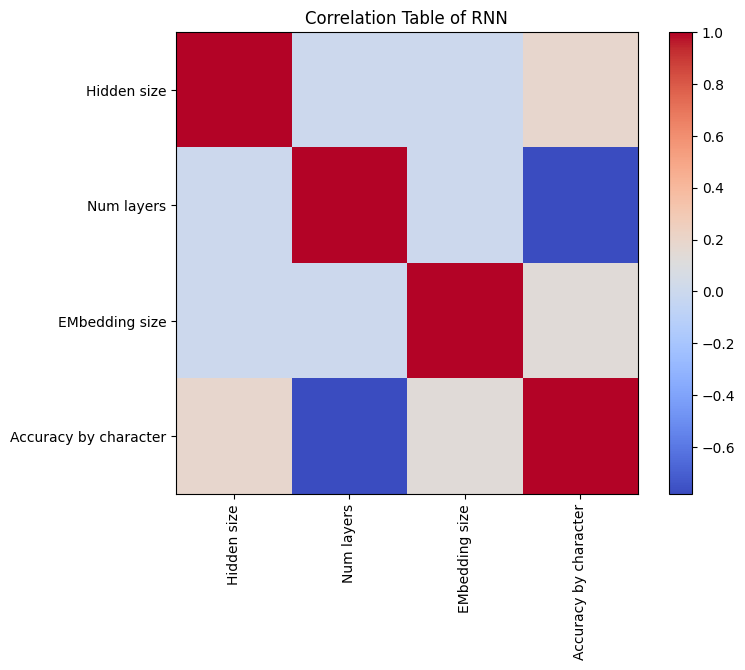

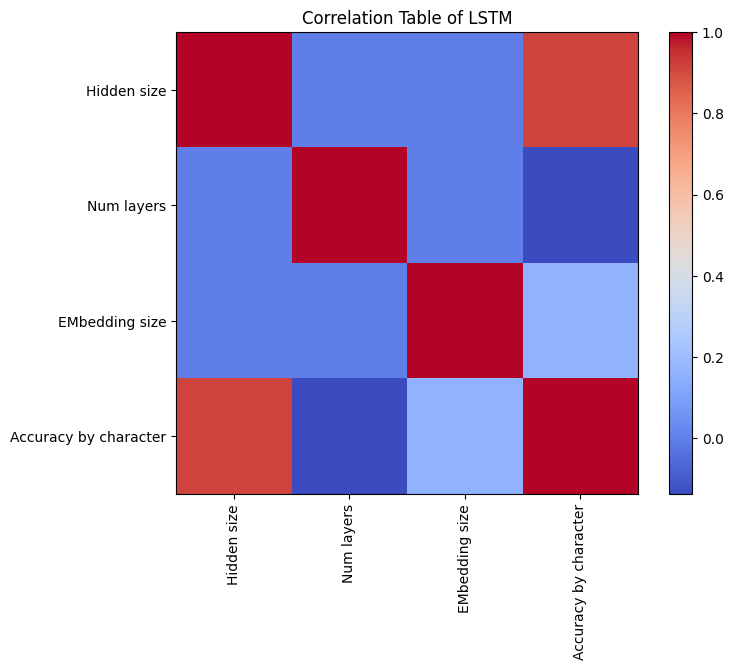

In [ ]:
corr = results1.corr()
plt.figure(figsize=(8, 6))
plt.title('Correlation Table of RNN')
plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.show()

print()

corr = results2.corr()
plt.figure(figsize=(8, 6))
plt.title('Correlation Table of LSTM')
plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.show()

## Part c - dropout

In [ ]:
lstm_do = Seq2SeqModel(len(eng_to_index), len(hindi_to_index), 64, 1, 64,'LSTM', 0.3).to(device)
lstm_do_train_error, lstm_do_train_accw, lstm_do_train_accc, lstm_do_val_error, lstm_do_val_accw, lstm_do_val_accc = checker(lstm_do)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


EPOCH : 1
Training loss = 0.7888456536037428
Training accuracy_by_word = 5.197975202925698
Training accuracy_by_char = 52.55851780404235

Validation loss = 0.552983899008144
Validation accuracy_by_word = 5.982605383443372
Validation accuracy_by_char = 57.48645734767182

EPOCH : 2
Training loss = 0.48623546071954676
Training accuracy_by_word = 8.596846846846846
Training accuracy_by_char = 66.80670132263573

Validation loss = 0.35590415177020157
Validation accuracy_by_word = 18.601320467242257
Validation accuracy_by_char = 76.46087988530856

EPOCH : 3
Training loss = 0.4310187362470068
Training accuracy_by_word = 11.126126126126126
Training accuracy_by_char = 69.0606185944021

Validation loss = 0.3184060914949937
Validation accuracy_by_word = 21.16302691721686
Validation accuracy_by_char = 78.16004105827304

EPOCH : 4
Training loss = 0.45954810891736736
Training accuracy_by_word = 9.722972972972974
Training accuracy_by_char = 64.91985472000218

Validation loss = 0.3289996764876626
Valida

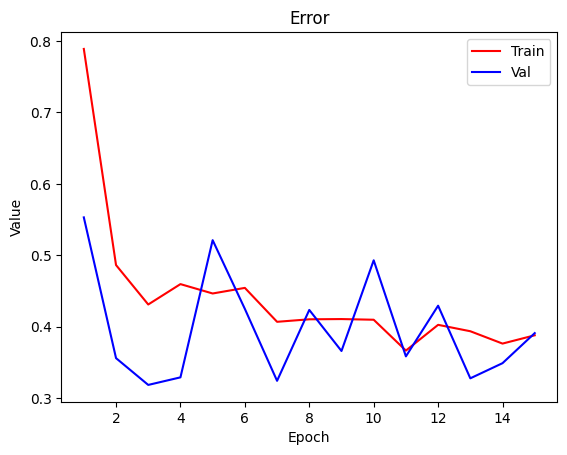

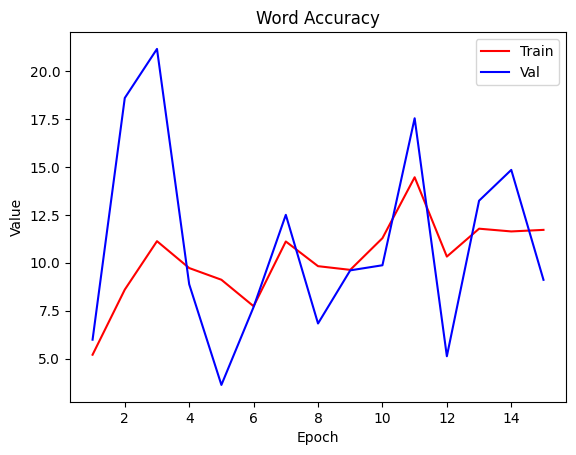

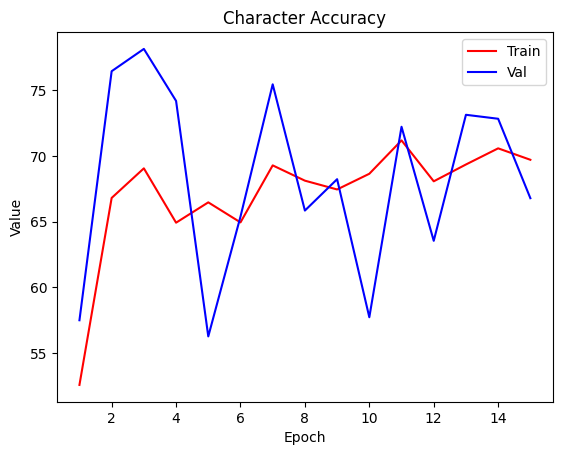

In [ ]:
plt.plot(range(1,16), lstm_do_train_error, color ='r')
plt.plot(range(1,16), lstm_do_val_error, color ='b')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(['Train','Val'])
plt.title('Error')
plt.show()

print()

plt.plot(range(1,16), lstm_do_train_accw, color ='r')
plt.plot(range(1,16), lstm_do_val_accw, color ='b')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(['Train','Val'])
plt.title('Word Accuracy')
plt.show()

print()

plt.plot(range(1,16), lstm_do_train_accc, color ='r')
plt.plot(range(1,16), lstm_do_val_accc, color ='b')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(['Train','Val'])
plt.title('Character Accuracy')
plt.show()

print()

## Part d

In [ ]:
class Attention(nn.Module):

  def __init__ (self, input_size, output_size, hidden_size, num_layers, embedding_size):
    super(Attention, self).__init__()
    self.input_size = input_size
    self.output_size = output_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.embedding_size = embedding_size

    self.encoder_embedding = nn.Embedding(input_size, embedding_size)
    self.decoder_embedding = nn.Embedding(output_size, embedding_size)

    self.encoder = nn.LSTM(embedding_size, hidden_size, num_layers=num_layers, batch_first=True)
    self.decoder = nn.LSTM(embedding_size + hidden_size, hidden_size, num_layers=num_layers, batch_first=True)

    self.a_score = nn.Sequential(nn.Linear(hidden_size + hidden_size, hidden_size),                  # 1 hidden from encoder 1 from decoder
                                 nn.Tanh(),                                                          # finally convert to 1 hidden to be multiplied and added for
                                 nn.Linear(hidden_size, 1))                                          # obtaining the score

    self.final = nn.Linear(hidden_size, output_size)

  def forward(self, input, target = None):
    input = self.encoder_embedding(input)

    hidden = torch.ones(self.num_layers, input.shape[0], self.hidden_size).to(device)
    cell = torch.ones(self.num_layers, input.shape[0], self.hidden_size).to(device)

    encoder_hidden_state = []
    for i in range(input.shape[1]):

      output, (hidden_cell, cell) = self.encoder(input[:,i,:].unsqueeze(1), (hidden, cell))
      encoder_hidden_state.append(output)

    encoder_hidden_state = torch.cat(encoder_hidden_state, dim = 1)

    if target is None:

      start = torch.Tensor([[65] for j in range(input.shape[0])]).to(int).to(device)[:,0,:]
      output = [start]
      outputs = []
      for i in range(target.shape[1]):

        dhidden = hidden[-1].unsqueeze(1).repeat(1, encoder_hidden_state.shape[1], 1)
        attention_scores = F.softmax(self.a_score(torch.cat((dhidden, encoder_hidden_state), dim = 2)), dim = 1)
        context_vector = torch.sum(attention_scores*encoder_hidden_state, dim = 1)

        intermediate1, (hidden, cell) = self.decoder(torch.concat((self.decoder(output[-1])[:,i,:], context_vector), dim = 1).unsqueeze(1), (hidden, cell))

      intermediate2 = self.final(intermediate1)
      intermediate3 = torch.argmax(intermediate2[-1], dim = 1)
      outputs.append(intermediate3)

      return torch.cat(output).transpose(2,1)

    else:


      target = self.decoder_embedding(target)
      target = torch.roll(target, 1, 1)
      target[:,0,:] = self.decoder_embedding(torch.Tensor([[65] for j in range(input.shape[0])]).to(int).to(device))[:,0,:]

      outputs = []

      for i in range(target.shape[1]):

        dhidden = hidden[-1].unsqueeze(1).repeat(1, encoder_hidden_state.shape[1], 1)
        attention_scores = F.softmax(self.a_score(torch.cat((dhidden, encoder_hidden_state), dim = 2)), dim = 1)
        context_vector = torch.sum(attention_scores*encoder_hidden_state, dim = 1)

        output, (hidden, cell) = self.decoder(torch.concat((target[:,i,:], context_vector), dim = 1).unsqueeze(1), (hidden, cell))

        outputs.append(output)

      outputs = torch.cat(outputs, dim = 1)
      final_output = self.final(outputs)

      # print(outputs.shape)

      return outputs.transpose(2,1)

In [ ]:
attention_lstm = Attention(len(eng_to_index), len(hindi_to_index), 66, 1, 66)

In [ ]:
attention_train_error, attention_train_accw, attention_train_accc, attention_val_error, attention_val_accw, attention_val_accc = checker(attention_lstm)

EPOCH : 1
Training loss = 2.7318925019857048
Training accuracy_by_word = 0.006756756756756757
Training accuracy_by_char = 11.379103656021975

Validation loss = 2.6221295920285312
Validation accuracy_by_word = 0.0
Validation accuracy_by_char = 14.008437225406505

EPOCH : 2
Training loss = 2.589735391977671
Training accuracy_by_word = 0.06752296851306752
Training accuracy_by_char = 23.108249847932115

Validation loss = 2.542368932203813
Validation accuracy_by_word = 0.07084814626714069
Validation accuracy_by_char = 27.751267769319483

EPOCH : 3
Training loss = 2.5266338726421735
Training accuracy_by_word = 0.2837391847292837
Training accuracy_by_char = 31.874859164343032

Validation loss = 2.4976272149519487
Validation accuracy_by_word = 0.255332656170645
Validation accuracy_by_char = 35.94399524985484

EPOCH : 4
Training loss = 2.4905746541581713
Training accuracy_by_word = 0.8333333333333334
Training accuracy_by_char = 38.273237765676015

Validation loss = 2.4734252149408515
Validation

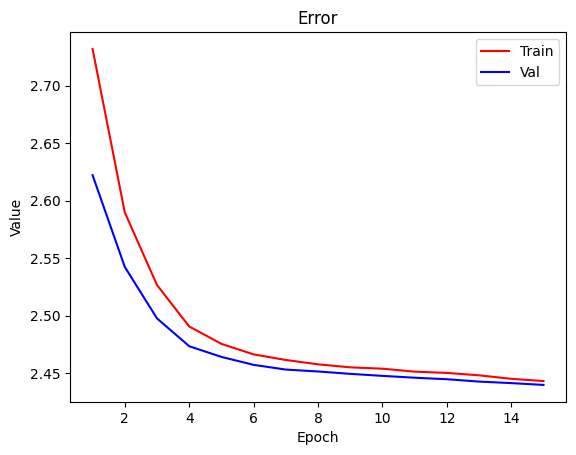

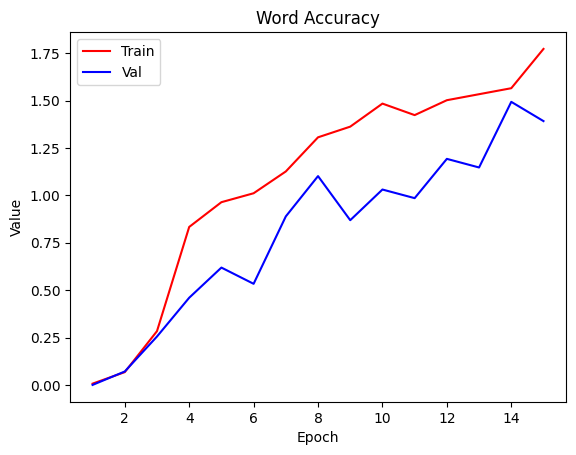

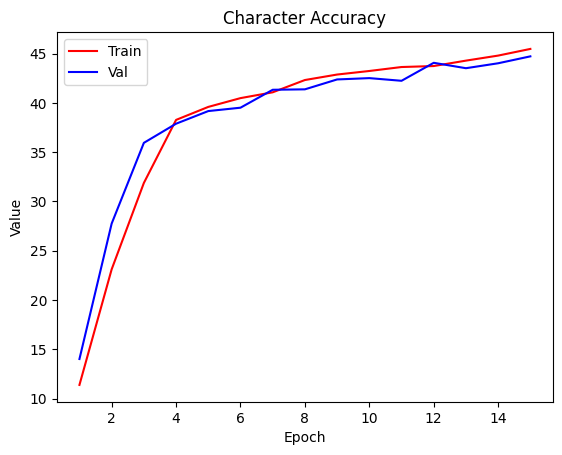

In [ ]:
plt.plot(range(1,16), attention_train_error, color ='r')
plt.plot(range(1,16), attention_val_error, color ='b')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(['Train','Val'])
plt.title('Error')
plt.show()

print()

plt.plot(range(1,16), attention_train_accw, color ='r')
plt.plot(range(1,16), attention_val_accw, color ='b')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(['Train','Val'])
plt.title('Word Accuracy')
plt.show()

print()

plt.plot(range(1,16), attention_train_accc, color ='r')
plt.plot(range(1,16), attention_val_accc, color ='b')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(['Train','Val'])
plt.title('Character Accuracy')
plt.show()

print()

## Test results of best LSTM, best RNN , Attention and dropout

In [ ]:
def testing(model):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.01)

  epoch_loss = 0
  epoch_accw = 0
  epoch_accc = 0

  for eng, hindi in test_loader:
      eng = eng.to(device)
      hindi = hindi.to(device)

      # eng = eng.view(eng.shape[0], -1)                                 # Flattening the list

      # optimizer.zero_grad()

      output = model(eng, hindi)
      # output = output.permute(0, 2, 1)

      # output1 = output.transpose(2, 1)
      # output1 = output1.view(-1, output1.shape[2])
      # hindi1 = hindi.view(-1)
      loss = criterion(output)

      epoch_loss += loss.item()

      epoch_accw += accuracy_by_word(output,hindi)
      epoch_accc += accuracy_by_char(output,hindi)

  test_loss = epoch_loss / len(test_loader)
  test_accw = epoch_accw / len(test_loader)
  test_accc = epoch_accc / len(test_loader)

  return test_loss, test_accw, test_accc

In [ ]:
rnn_loss, rnn_accw, rnn_acc = testing(rnn_s2s)
lstm_loss, lstm_accw, lstm_acc = testing(lstm_64_3_64)
attention_lstm_loss, attention_lstm_accw, attention_lstm_acc = testing(attention_lstm)
lstm_do_loss, lstm_do_accw, lstm_do_acc = testing(lstm_do)

print('Best RNN : Loss, Word Accuracy and Character Accuracy')
print(rnn_loss)
print(rnn_accw)
print(rnn_acc)
print()

print('Best LSTM : Loss, Word Accuracy and Character Accuracy')
print(lstm_loss)
print(lstm_accw)
print(lstm_acc)
print()

print('ATtention : Loss, Word Accuracy and Character Accuracy')
print(attention_lstm_loss)
print(attention_lstm_accw)
print(attention_lstm_acc)
print()

print('Dropout : Loss, Word Accuracy and Character Accuracy')
print(lstm_do_loss)
print(lstm_do_accw)
print(lstm_do_acc)
print()

Best RNN : Loss, Word Accuracy and Character Accuracy
0.3815601946165164
15.123366013071895
71.29424049080913

Best LSTM : Loss, Word Accuracy and Character Accuracy
0.3533637921015422
12.600081699346404
70.91070971398791

ATtention : Loss, Word Accuracy and Character Accuracy
2.436039388179779
1.724264705882353
45.88033443385772

Dropout : Loss, Word Accuracy and Character Accuracy
0.44564513117074966
4.6838235294117645
61.08429994909776

